In [1]:
!which python

/home/drs4568/peax/.venv/bin/python


In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import peax

from jax import lax
from scipy.linalg import schur, eigvals

from peax.fpta import LSTQD, load_buffer_data

In [4]:
np.set_printoptions(precision=4, suppress=True)

In [5]:
def discretize_action(action_idx: int, num_actions_per_dim: int, max_force: float) -> jnp.ndarray:
    """Convert discrete action index to continuous force.

    Args:
        action_idx: Discrete action index
        num_actions_per_dim: Number of discrete actions per dimension
        max_force: Maximum force magnitude

    Returns:
        2D force vector
    """
    # Convert 1D index to 2D grid coordinates
    fx_idx = action_idx // num_actions_per_dim
    fy_idx = action_idx % num_actions_per_dim

    # Map to force values
    force_values = np.linspace(-max_force, max_force, num_actions_per_dim)
    fx = force_values[fx_idx]
    fy = force_values[fy_idx]

    return jnp.array([fx, fy])

In [6]:
basis = [lambda x: 1]
basis += [lambda x, idx=i: jnp.exp(0.1*(1 - 2*x[0])*x[idx]) for i in range(6)]

In [7]:
lstq = LSTQD(basis)

In [8]:
data_dir = "/home/drs4568/peax/examples/"
buffer, buffer_state, meta_data = load_buffer_data(data_dir, batch_size=1000)

Loading metadata...

Dataset Info:
Episodes collected: 100
Total transitions: 15654
Captures: 95 (95.0%)
Timeouts: 5 (5.0%)
Avg Pursuer Reward: -0.19
Avg Evader Reward: 0.19

Buffer Shapes:
  observation: (12,)
  action: ()
  reward: ()
  next_observation: (12,)
  done: ()
  agent_id: ()

Loading buffer state...
✅ Data loaded successfully!


In [9]:
key = jax.random.PRNGKey(0)
batch = buffer.sample(buffer_state, key)
 

In [10]:
obs = batch.experience["observation"]
actions = batch.experience["action"]
p1_obs, p2_obs = lstq.get_p_obs(obs)

In [11]:
action_transform = lambda a: discretize_action(a, num_actions_per_dim=3, max_force=5.0)

In [12]:
actions_ = np.array([action_transform(a) for a in actions])

In [13]:
np.unique(actions_, axis=0)

array([[-5., -5.],
       [-5.,  0.],
       [-5.,  5.],
       [ 0., -5.],
       [ 0.,  0.],
       [ 0.,  5.],
       [ 5., -5.],
       [ 5.,  0.],
       [ 5.,  5.]], dtype=float32)

(array([129.,  67.,  67.,  91., 100., 101., 101.,  75., 126., 143.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <BarContainer object of 10 artists>)

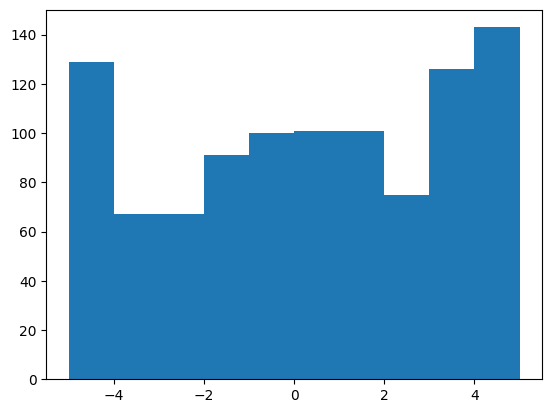

In [14]:
plt.hist(p1_obs[:,0])

Current observation space is 

x pos

y pos

x vel

y vel

time 

id

In [15]:
C = np.load("/home/drs4568/peax/C.npy")

In [16]:
C

array([[-2.7618, -1.4046,  0.0178, -0.1112,  0.0162,  2.7116, -2.8882],
       [ 1.4201, -0.0068, -0.0089,  0.0609,  0.0022, -3.0595,  2.8135],
       [-0.0178,  0.0089,  0.    ,  0.0002, -0.0003,  0.0029,  0.0028],
       [ 0.1118, -0.0612, -0.0002,  0.    ,  0.0004, -0.0306, -0.0485],
       [-0.0162, -0.0022,  0.0003, -0.0004, -0.    ,  0.0013,  0.0129],
       [-2.7084,  3.0478, -0.0029,  0.0305, -0.0013, -0.0072,  2.265 ],
       [ 8.4041, -2.8099, -0.0028,  0.0481, -0.0129, -2.2555, -2.7602]],
      dtype=float32)

The embedding maps are given by $Y^k(x)$ = Y_{2k}(

In [17]:
np.allclose(C, -C.T)

False

In [18]:
C = (C - C.T) / 2.0

In [19]:
C

array([[ 0.    , -1.4123,  0.0178, -0.1115,  0.0162,  2.71  , -5.6462],
       [ 1.4123,  0.    , -0.0089,  0.0611,  0.0022, -3.0536,  2.8117],
       [-0.0178,  0.0089,  0.    ,  0.0002, -0.0003,  0.0029,  0.0028],
       [ 0.1115, -0.0611, -0.0002,  0.    ,  0.0004, -0.0306, -0.0483],
       [-0.0162, -0.0022,  0.0003, -0.0004,  0.    ,  0.0013,  0.0129],
       [-2.71  ,  3.0536, -0.0029,  0.0306, -0.0013,  0.    ,  2.2603],
       [ 5.6462, -2.8117, -0.0028,  0.0483, -0.0129, -2.2603,  0.    ]],
      dtype=float32)

In [20]:
U, Q = schur(C, output="real")

In [21]:
U

array([[ 0.    ,  7.9322,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [-7.9322,  0.    , -0.    , -0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , -0.    , -0.811 ,  0.    , -0.    , -0.    ],
       [ 0.    ,  0.    ,  0.811 , -0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0006,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , -0.0006,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]],
      dtype=float32)

In [22]:
Q

array([[-0.8058,  0.0489,  0.5649,  0.17  , -0.0142,  0.0072,  0.0046],
       [ 0.4955,  0.2298,  0.7791, -0.3075, -0.0057,  0.0026,  0.0056],
       [ 0.0003, -0.0025,  0.0026, -0.0033, -0.4715, -0.581 , -0.6634],
       [-0.0043,  0.0169,  0.0141,  0.0153,  0.8368, -0.0584, -0.5437],
       [ 0.0011, -0.0017, -0.007 , -0.0146, -0.2768,  0.8117, -0.514 ],
       [ 0.3105, -0.4928,  0.2527,  0.7725, -0.0083,  0.0096, -0.0034],
       [ 0.0939,  0.8377, -0.0983,  0.5285, -0.0214,  0.0056,  0.0041]],
      dtype=float32)

In [23]:
def sort_schur(Q, U):
    pred_eigs = eigvals(U)
    print(pred_eigs)
    pred_eigs = [eig.imag for eig in pred_eigs]
    print(pred_eigs)
    return pred_eigs ,Q

def Y(x, basis, Q, w):
    """
    Q: d x d matrix
    w: d set of eigvalues 
    """
    d = Q.shape[1]
    assert d % 2 == 0, "If odd please add column, eigvalue to make even"
    Y = jnp.zeros(d)
    B_x = jnp.array([b(x) for b in basis])[:, None]
    print(B_x.shape)
    print((Q.T @ B_x).shape)
    Y = jnp.sqrt(w)*(Q.T @ B_x)
    return Y

def print_basis(C):
    return " + ".join([f"{C[i][j]:.2f}*b_{i + 1},{j + 1}" for i in range(C.shape[0]) for j in range(C.shape[1])])

In [24]:
print_basis(C)

'0.00*b_1,1 + -1.41*b_1,2 + 0.02*b_1,3 + -0.11*b_1,4 + 0.02*b_1,5 + 2.71*b_1,6 + -5.65*b_1,7 + 1.41*b_2,1 + 0.00*b_2,2 + -0.01*b_2,3 + 0.06*b_2,4 + 0.00*b_2,5 + -3.05*b_2,6 + 2.81*b_2,7 + -0.02*b_3,1 + 0.01*b_3,2 + 0.00*b_3,3 + 0.00*b_3,4 + -0.00*b_3,5 + 0.00*b_3,6 + 0.00*b_3,7 + 0.11*b_4,1 + -0.06*b_4,2 + -0.00*b_4,3 + 0.00*b_4,4 + 0.00*b_4,5 + -0.03*b_4,6 + -0.05*b_4,7 + -0.02*b_5,1 + -0.00*b_5,2 + 0.00*b_5,3 + -0.00*b_5,4 + 0.00*b_5,5 + 0.00*b_5,6 + 0.01*b_5,7 + -2.71*b_6,1 + 3.05*b_6,2 + -0.00*b_6,3 + 0.03*b_6,4 + -0.00*b_6,5 + 0.00*b_6,6 + 2.26*b_6,7 + 5.65*b_7,1 + -2.81*b_7,2 + -0.00*b_7,3 + 0.05*b_7,4 + -0.01*b_7,5 + -2.26*b_7,6 + 0.00*b_7,7'

In [25]:
w = np.abs([eig for eig in eigvals(U)])

In [26]:
if Q.shape[1] % 2 != 0:
    Q_ = np.concatenate((Q, jnp.zeros((Q.shape[0], 1))), axis=1)
    w = np.concatenate((w, [0.0]))

In [27]:
Q_.shape[1] % 2

0

In [28]:
w.shape

(8,)

In [29]:
Y_x = Y(p1_obs.flatten(), basis, Q_, w[:,None])

(7, 1)
(8, 1)


In [30]:
Y_ = lambda x: Y(x, basis, Q_, w[:, None])
Y_X = jax.vmap(Y_)(p1_obs)
Y_Y = jax.vmap(Y_)(p2_obs)

(7, 1)
(8, 1)
(7, 1)
(8, 1)


In [31]:
Y_X.shape

(1000, 8, 1)

In [32]:
from peax.util import plot_disc_game

In [37]:
def get_y_axis_text(basis, w):
    return " + ".join([f"{w[i]:.2f}*b_{i + 1}" for i in range(len(basis))])

In [38]:
get_y_axis_text(basis, Q[:,0])

'-0.81*b_1 + 0.50*b_2 + 0.00*b_3 + -0.00*b_4 + 0.00*b_5 + 0.31*b_6 + 0.09*b_7'

In [41]:
w

array([7.9322, 7.9322, 0.811 , 0.811 , 0.0006, 0.0006, 0.    , 0.    ])

Text(0.5, -0.1, '0.05*b_1 + 0.23*b_2 + -0.00*b_3 + 0.02*b_4 + -0.00*b_5 + -0.49*b_6 + 0.84*b_7')

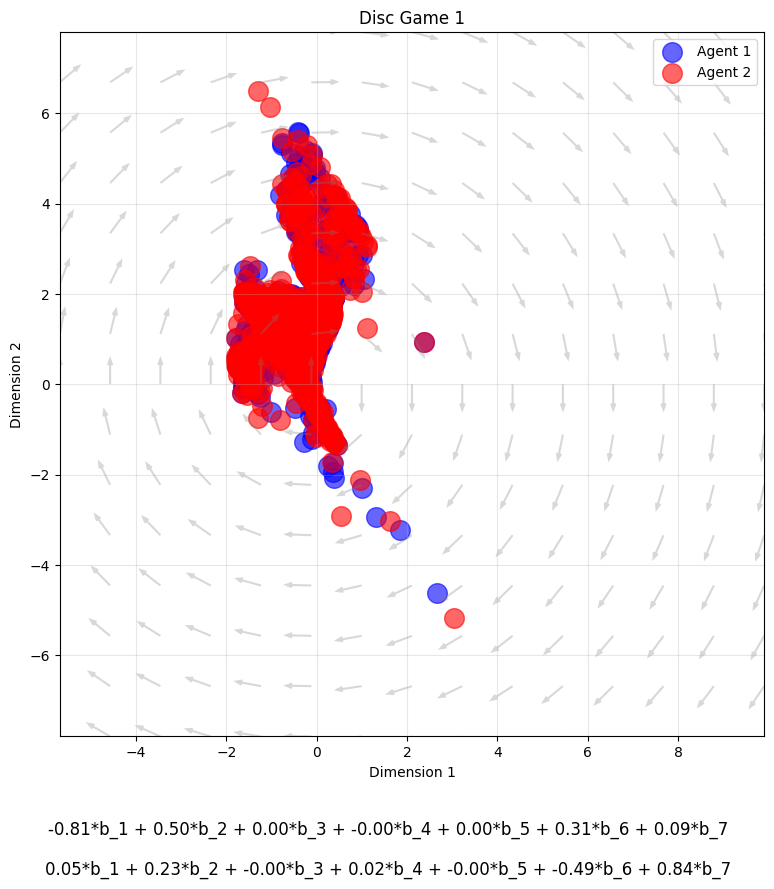

In [42]:
fig = plot_disc_game(Y_X.squeeze(), Y_Y.squeeze(), grey=None, title="Disc Game 1", plot_grey=False)
#plt.figtext(-0.05, 0.5, get_y_axis_text(basis, Q[:,1]), fontsize=12, rotation='vertical', va='center')
plt.figtext(0.5, -0.05, get_y_axis_text(basis, Q[:,0]), fontsize=12, ha='center')
plt.figtext(0.5, -0.1, get_y_axis_text(basis, Q[:,1]), fontsize=12, ha='center')

Text(0.5, -0.05, '0.17*b_1 + -0.31*b_2 + -0.00*b_3 + 0.02*b_4 + -0.01*b_5 + 0.77*b_6 + 0.53*b_7')

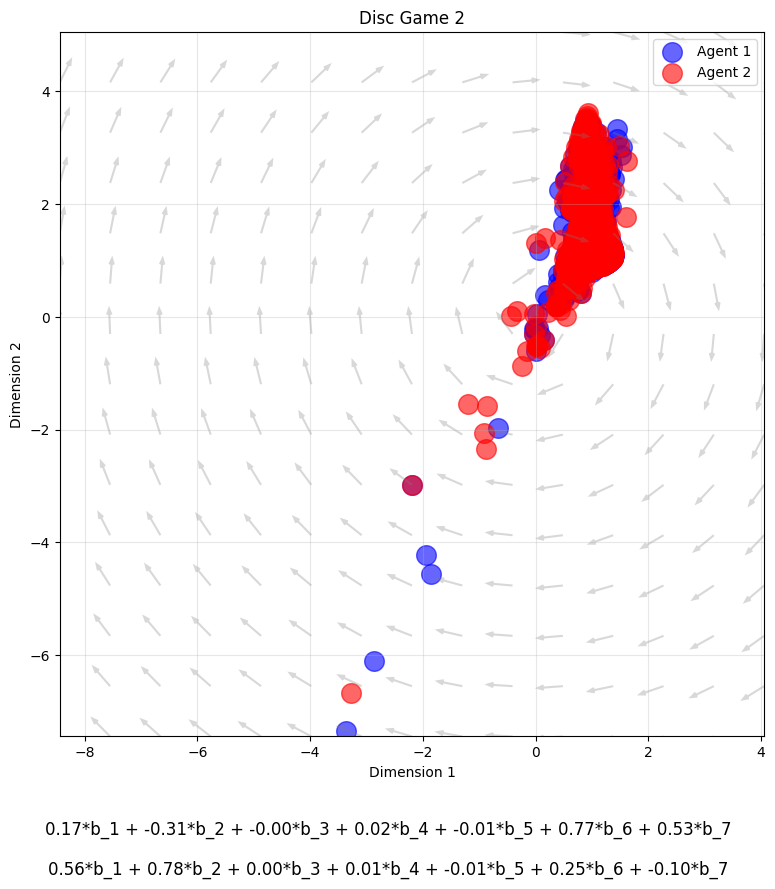

In [43]:
fig = plot_disc_game(Y_X[:,2:4].squeeze(), Y_Y[:,2:4].squeeze(), grey=None, title="Disc Game 2", plot_grey=False)
plt.figtext(0.5, -0.1, get_y_axis_text(basis, Q[:,2]), fontsize=12, ha='center')
plt.figtext(0.5, -0.05, get_y_axis_text(basis, Q[:,3]), fontsize=12, ha='center')